In [6]:
# ________Import machine learning libraries__________
import torch
import torchvision
import torch.nn as nn
# The DataLoader class provides an iterable (an object that can be looped over like a list) over a given dataset
# We perform an iteration over the MNIST dataset of handwritten digits
from torch.utils.data import DataLoader
# The torchvision.transforms module provides a set of composable image transformations
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# torch.device allows us to specify the device type responsible for loading a tensor into memory and storing the tensor during runtime
# GPU access
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# _________Parameters_________
# We specify the size of the input images, which in the case of the MNIST image is $28\times28$
input_size = 28*28
# CIFAR-10 image size
# input_size = 3*32*32
# Both MNIST and CIFAR have 10 mutually exclusive classes
num_classes = 10
# We specify the depth of the neural network
hidden_layers = 12
# We define the learning parameters
learning_rate = 0.00005
batch_size = 128
num_epochs = 100
momentumSGD = 0.8


# ___________Load the MNIST or CIFAR image dataset___________
# The torchvision.datasets module allows us to use the pre-classified dataset of handwritten digits called MNIST
# We transform the images to tensors
# We create two dataloaders
# The first is used to train the network, the second to test the neural network
train_data = torchvision.datasets.MNIST('MNIST', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST('MNIST', train=False, transform=torchvision.transforms.ToTensor())


# By using shuffle=True, a random generator permutes the indices of all the image samples so that the images are shuffled in each epoch during training
# Thus, we have 128 images arranged in random order in each epoch
# In chapter $\ref{ChapterGeneralization}$, we discussed how this enhances the network's ability to generalize
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# ________Multilayer Perceptron________
"""
The class NN defines the blueprint of the multilayer perceptron.
"""
class NN:
    """
    This constructor initializes the instance attributes when an object of this class is created.
    """
    def __init__(self, N, variances, lr=learning_rate):
        # Dimensions of each layer in the network
        self.N = N
        # Weight variance $\sigma_w^{2}$
        self.variances = variances
        # Learning rate
        self.lr = lr

        # The list layers stores the generated layers
        layers = []
        for i in range(len(N) - 1):
            # We create Gaussian linear layers and append them to the layers list using the layer dimensions stored in N
            # These layers will have the pre-activations
            layers.append(torch.nn.Linear(N[i], N[i + 1]))
            # Using layers[-1].weight and layers[-1].bias together with torch.nn.Parameter, we can access and modify the parameters of each layer
            # We initialize them according to a Gaussian distribution. For the biases, we use the bias variance $\sigma_b^{2}$ as variance,
            # and for the weights, we scale the weight variance $\sigma_w^{2}$ with the layer width as variance $\cite{erdmenger2021quantifying}$
            layers[-1].weight = torch.nn.Parameter(
                torch.normal(mean=torch.zeros((N[i + 1], N[i])),
                              # Note: must scale var_W by layer width!
                              std=np.sqrt(variances[0] / N[i])))
            layers[-1].bias = torch.nn.Parameter(
                torch.normal(mean=torch.zeros((N[i + 1])),
                              std=np.sqrt(variances[1])))
            # We run the pre-activations through activation functions by stacking a tanh layer on top of each linear layer
            layers.append(torch.nn.Tanh())

        # We create the deep neural network nn.model by stacking the generated layers in the layers list in the order in which they were created (see chapter $\ref{ChapterArchitecture}$)
        # We do this by using a sequential container called nn.Sequential
        self.model = torch.nn.Sequential(*layers)
        # We pass the neural network to the GPU
        self.model.to(device)
        # For updating the neural network parameters (self.model.parameters()), we use the Mini-Batch SGD algorithm (see chapter $\ref{GD and Backprop}$) with the given learning rate and momentum
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentumSGD)



    # ___________Training Loop___________
    # We use the cross-entropy loss as the cost function (see chapter $\ref{GD and Backprop}$)
    criterion = nn.CrossEntropyLoss()
    '''
    With this cost function, we train the network for a number of $num$_$epochs$ using the training dataset.
    As explained in chapter $\ref{GD and Backprop}$, we use the Mini-Batch SGD algorithm to minimize the discrepancy
    between the predictions of the network and the labels by updating the parameters of the network.
    '''
    def train(self, train_loader, test_loader, num_epochs):
        # Stores the discrepancies between the predictions of the network and the labels
        losses = []
        running_loss = 0.0
        running_correct = 0
        n_total_steps = len(train_loader)
        # We train the network for a number of $num$_$epochs$ (see Mini-Batch Stochastic Gradient Descent pseudo-code in chapter $\ref{GD and Backprop}$)
        for epoch in range(num_epochs):
            # We train the neural network with the training dataset
            self.model.train()
            # We iterate through the images and the labels of these images in the train_loader
            for i, (images, labels) in enumerate(train_loader):
                # Images are converted to a vector (tensor) and passed to the GPU
                images = images.view(-1, input_size).to(device)
                labels = labels.to(device)

                # ________Forward Pass_________
                # The information from the input images is forward propagated through the layers of the network
                # so that the network can make a prediction/output with the given parameter settings
                outputs = self.model(images)
                # Compute the deviations between the predictions of the network and the labels of the input images
                loss = self.criterion(outputs, labels)

                # ________Backward Pass_________
                # We clear the gradients from the previous step as they are no longer needed
                self.optimizer.zero_grad()
                # Backpropagate the deviations between the predictions of the network and the labels
                # so that the parameters can be updated using Mini-Batch SGD
                loss.backward()

                # Update the parameters
                self.optimizer.step()

                # We log the performance of the neural network on the training dataset
                losses.append(loss.item())
                if (i + 1) % 100 == 0:
                    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')


    # ________Evaluation________
    '''
    The eval(self, test$_$loader)$ function tests whether the neural network can classify images from the test dataset.
    This evaluates whether the network is able to correctly classify unseen images, and therefore if the network is able to generalize.
    '''
    def eval(self, test_loader):
        # We use the test dataset
        self.model.eval()
        # During the test phase, we do not compute gradients
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            # Iterate through the images and the labels in the test_loader
            for images, labels in test_loader:
                # Images are converted to a vector (tensor) and passed to the GPU
                images = images.view(-1, input_size).to(device)
                labels = labels.to(device)
                # Forward propagate the information from the input images through the layers of the network
                outputs = self.model(images)

                # Track the number of samples and correct classifications by comparing predictions with labels
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
            # Print the classification accuracy of the neural network on the test dataset
            acc = 100.0 * n_correct / n_samples
            print(f'Accuracy: {acc:.2f}%')

'''
The function get$_$wide$_$network(input$_$dim, output$_$dim, layers, variances)$ defines the architecture of the neural network,
including the number of layers and the dimensions of each layer.
'''
def get_wide_network(input_dim, output_dim, layers, variances):
    if layers < 3:
        raise Exception("Too few layers; the minimum allowed depth is 3")
    # The first layer and hidden layers have the same dimension as the input, except for the last hidden layer,
    # which has a width of 400 neurons. The output layer has as many neurons as the MNIST dataset classes (10).
    widths = [input_dim] * layers + [400, output_dim]
    return NN(widths, variances)


def get_shrinking_network(input_dim, output_dim, layers, variances):
    diff = input_dim - output_dim
    if layers > diff:
        raise Exception("Specified number of layers exceeds the maximum value consistent\n" +
                        f"with monotonic reduction in layer widths. Max allowed depth is {diff}")

    shrink = int(diff / layers)

    layers = [input_dim - shrink * i for i in range(layers)] + [output_dim]
    return NN(layers, variances)


#________Hooks________
from typing import Tuple, Any
import pickle

class HookRegister:
    def __init__(self):
        """
        Initialize a new HookRegister.
        It is inactive initially since no layers are connected.
        Remember to reactivate it every time you add a new layer that you want to be tracked.
        """
        self.register = [[]]
        self.layers = []
        self.conns = []
        self.i = 0

    # With this function, the instances can be called

    def __call__(self, name: str, forward: Tuple[torch.tensor], backward: Tuple[
        torch.tensor]):
        """
        Add forward[0] to the local storage.
        :param name: str = name of the current layer
        :param forward: Tuple[torch.tensor] = forward-propagated input
        :param backward: Tuple[torch.tensor] = backward-propagated error
        :return: void
        """
        self.register[self.i].append(forward[0].detach())

    def __getitem__(self, item: bool):
        """
        This function sets the state of the register to either True or False.
        If True, the hooks are created and the pre-activations are stored.
        If False, the hooks are removed.
        :param item: bool = state of the register, either True or False
        :return: void
        """
        if item:
            # Iterate over all the layers stored in the layers list via the hook(self, layer: torch.nn.Module) function
            for layer in self.layers:
                # Register a forward hook to each layer
                # Add the forward hook to the list register
                self.conns.append(layer.register_forward_hook(self))

        else:
            for conn in self.conns:
                # Remove the forward hook from the layers
                conn.remove()

    def hook(self, layer: torch.nn.Module):
        """
        This function stores the layers of the given neural network together with all its parameters in the list layers.
        Add another layer to observation.
        :param layer: torch.nn.Module = new layer to observe
        :return: void
        """
        self.layers.append(layer)

    def save(self, file: str):
        """
        This function saves the register as a pickle file.
        :param file: str = filename
        :return: void
        """
        with open(file, "wb") as doc:
            pickle.dump(self.register, doc)
        self.clear()

    def clear(self):
        """
        This function clears the memory of the register.
        :return: void
        """
        self.register = []

    def add(self, addition: Any):
        """
        This function adds all weight variances of a given neural network to the register
        and stores them in a sublist of the list register.
        :param addition: Any = content to add
        :return: void
        """
        self.register[self.i].append(addition)

    def step(self):
        """
        This function adds a new sublist to the register and points to it.
        :return: void
        """
        self.register.append([])
        self.i += 1

    def add_parameters(self, network: torch.nn.Sequential):
        """
        This function adds a new sublist to the register and points to it.
        :param network: torch.nn.Sequential = Network to take the parameters from
        :return: void
        """
        # Store the weights and biases of a given neural network in the weights and biases lists
        weights = []
        biases = []
        for name, para in network.named_parameters():
            if name[-6:] == "weight":
                weights.append(para.detach())
            elif name[-4:] == "bias":
                biases.append(para.detach())
            else:
                raise Exception(f"Classification of parameter {name} failed")

        self.add(weights)
        self.add(biases)


def hook_network(network: torch.nn.Sequential) -> HookRegister:
    """
    This function takes a neural network and stores its pre-activations and parameters in a register, i.e., adds data hooks to the network layers.
    :param network: nn.Sequential = Sequential containing the layers
    :return: HookRegister = Register preserving the hooks
    """
    # Create an instance of the HookRegister class, namely a register
    register = HookRegister()
    for layer in network:
        if isinstance(layer, torch.nn.Tanh):
            # Call the hook function and give it the layers of the network together with the corresponding parameters
            # This function adds data hooks to the layers
            register.hook(layer)
    return register


# _________Executor_________
def train_networks(*varss):
    for i, vars in enumerate(varss):
        # Create a deep neural network
        wide_network = get_wide_network(input_size, 10, hidden_layers, vars)

        # Create a register and feed it the neural network so that hooks can be added
        register = hook_network(wide_network.model)

        # Add the weight variances to the register and store them inside a sublist of the register
        # --> register = [[weight variances]]
        register.add(vars)
        # Create a new sublist and point to it
        # --> register = [[weight variances], []]
        register.step()

        # Add the weights and biases of the untrained neural network to the newly created sublist
        # --> register = [[weight variances], [weights, biases]]
        register.add_parameters(wide_network.model)
        # Create a new sublist and point to it
        # --> register = [[weight variances], [weights_pre, biases_pre], []]
        register.step()

        # Activate the register to create forward hooks and store the layers inside the register
        # --> conns = [forward_hook_pre_training(tanh)] and register = [[weight variances], [weights_pre, biases_pre], [forward_hook_pre_training(tanh)]]
        register[True]
        print(f"For var_w=({vars[0]}), the accuracy of the network with no training is:")
        # Test the network with only one batch from the dataloader
        wide_network.eval([next(iter(test_loader))])
        # Create a new sublist and point to it
        # --> register = [[weight variances], [weights_pre, biases_pre], [forward_hook_pre_training(tanh)], []]
        register.step()

        # For training, remove the forward hooks so no layers are added to the register
        register[False]
        # Train the network with the given training settings
        wide_network.train(train_loader, test_loader, num_epochs)
        print(f"The accuracy of the network after training, where var_w=({vars[0]}), is:")

        # Add the weights and biases after training to the newly created sublist
        # --> register = [[weight variances], [weights_pre, biases_pre], [forward_hook_pre_training(tanh)], [weights_post, biases_post]]
        register.add_parameters(wide_network.model)
        # Create a new sublist and point to it
        # --> register = [[weight variances], [weights_pre, biases_pre], [forward_hook_pre_training(tanh)], [weights_post, biases_post], []]
        register.step()

        # Add the layers after training to the register
        # --> conns = [forward_hook_pre_training(tanh), forward_hook_post_training(tanh)]
        # and register = [[weight variances], [weights_pre, biases_pre], [forward_hook_pre_training(tanh)], [weights_post, biases_post], [forward_hook_post_training(tanh)]]
        register[True]
        # Using one batch from the dataloader, test whether the network can classify unseen images
        wide_network.eval([next(iter(test_loader))])  # Take only one batch from the dataloader for testing

        # Save the register as a pickle file
        register.save(f"var=({vars[0]}, {vars[1]})_depth=40_data.pkl")

torch.cuda.empty_cache()

# Create different samples of weight variances
vars_weight = np.linspace(1.75, 1.75, 1, True).tolist()
# Fix the bias and pass the weights and biases to the following function
# By executing the following line, we start the program for the architecture, training, and evaluation of the deep neural network
train_networks(*[(var_weight, 0.05) for var_weight in vars_weight])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 439kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

For var_w=(1.75), the accuracy of the network with no training is:
Accuracy: 9.38%
Epoch [1/100], Step [100/469], Loss: 2.1093
Epoch [1/100], Step [200/469], Loss: 1.8627
Epoch [1/100], Step [300/469], Loss: 1.6804
Epoch [1/100], Step [400/469], Loss: 1.6448
Epoch [2/100], Step [100/469], Loss: 1.4938
Epoch [2/100], Step [200/469], Loss: 1.4148
Epoch [2/100], Step [300/469], Loss: 1.4279
Epoch [2/100], Step [400/469], Loss: 1.3642
Epoch [3/100], Step [100/469], Loss: 1.2906
Epoch [3/100], Step [200/469], Loss: 1.2724
Epoch [3/100], Step [300/469], Loss: 1.2930
Epoch [3/100], Step [400/469], Loss: 1.2185
Epoch [4/100], Step [100/469], Loss: 1.2832
Epoch [4/100], Step [200/469], Loss: 1.2378
Epoch [4/100], Step [300/469], Loss: 1.1977
Epoch [4/100], Step [400/469], Loss: 1.2076
Epoch [5/100], Step [100/469], Loss: 1.2028
Epoch [5/100], Step [200/469], Loss: 1.2835
Epoch [5/100], Step [300/469], Loss: 1.2078
Epoch [5

\subsubsection{Relative entropy and analysis of the layer distribution}\label{RECode}
For the implementation of the relative entropy, only the term $\langle Q^{[l+m]} \rangle_{p}$ is problematic \cite{erdmenger2021quantifying}, since it consists of the recursive functions $f_{j,k}^{[0]}$ and $f_{j}^{[0]}$.
Due to the high dimensionality of this problem, we solve it numerically using the Monte Carlo method.
\\
This method allows us to compute a multidimensional integral over a subregion $\chi$ of $\mathbb{R}^{d}$, where the continuous random variable $\vec{x}$ is high-dimensional, and therefore lives in a space that is too large for an exact calculation
\begin{equation}
\int_{\chi}dx\,p(\vec{x})f(\vec{x}) = \mathbb{E}_{p}[f(\vec{x})].
\end{equation}
Here $p$ is the probability density and $f$ is some function. The idea now is to sample $n_{MC}$ $x_{i}$, $i\,\epsilon\,\{1,...,n_{MC}\}$ from $p$, substitute these $x_{i}$ into $f$ and compute the average. For the limit of $n_{MC}\rightarrow \infty$, the strong law of large numbers allows us to say
\begin{equation}
\mathbb{E}_{p}[f(\vec{x})] \approx \frac{1}{n_{MC}} \sum_{i}^{n_{MC}}f(\vec{x}_{i}) \text{ , } \vec{x}_{i}\sim p.
\end{equation}
Next, we enhance the Monte Carlo method with importance sampling. To do this, we introduce a new probability density function $q$ that must be $>0$ if $p(\vec{x})f(\vec{x}) \neq 0$. We thus obtain an expected value of the function $[\frac{p(\vec{x})}{q(\vec{x})}f(\vec{x})]$ with respect to $q$
\begin{equation}
\mathbb{E}_{p}[f(\vec{x})] = \int_{\chi}dx\,p(\vec{x})f(\vec{x})\frac{q(\vec{x})}{q(\vec{x})} = \int_{\chi}dx\, q(\vec{x})[\frac{p(\vec{x})}{q(\vec{x})}f(\vec{x})] = \mathbb{E}_{q}[\frac{p(\vec{x})}{q(\vec{x})}f(\vec{x})].
\end{equation}
Subsequently, the application of the Monte Carlo method leads to
\begin{equation}
\mathbb{E}_{q}\left[\frac{p(\vec{x})}{q(\vec{x})}f(\vec{x})\right] \approx \frac{1}{n_{MC}} \sum_{i}^{n_{MC}}\frac{p(\vec{x})}{q(\vec{x})}f(\vec{x})\text{ , } \vec{x}_{i}\sim q,
\end{equation}
where $n_{MC}$ $x_{i}$ are sampled from the distribution $q$. In simple terms, with importance sampling, we weight each sample $x_{i}$ by an amount proportional to how often it occurs in the ensemble. The magic of this method for our case is that we can simply choose $q$ in (\ref{importance}) to be a Gaussian.
\\
We now apply it to $f_{j,k}^{[0]}$ and $f_{j}^{[0]}$ (see (\ref{integrals})) and obtain
\begin{equation}
f_{j}^{[0]} = \frac{1}{\sqrt{2\pi(\sigma_{p,j}^{[0]})^2}} \int dz^{[0]}_{j}\, \mathrm{e}^{- \frac{1}{2}\left(\frac{z_{j}^{[0]} - \mu_{p,j}^{[0]}}{\sigma_{p,j}^{[0]}}\right)^2}\sigma_{T}(z_{j}^{[0]}) = \frac{1}{n_{MC}}\sum_{s=1}^{n_{MC}}\sigma_{T,s}(z_{j}^{[0]}),
\end{equation}
and
\begin{equation}
\begin{split}
    f_{j,k}^{[0]} &= \frac{1}{2\pi\sigma_{p,j}^{[0]}\sigma_{p,k}^{[0]}} \int dz^{[0]}_j{d}z^{[l]}_{k}\,\mathrm{e}^{-\frac{1}{2}\left(\frac{z_{j}^{[0]} - \mu_{p,j}^{[0]}}{\sigma_{p,j}^{[0]}}\right)}\mathrm{e}^{-\frac{1}{2}\left(\frac{z_{j}^{[0]} - \mu_{p,k}^{[0]}}{\sigma_{p,k}^{[0]}}\right)}\sigma_{T}(z_{j}^{[0]})\sigma_{T}(z_{k}^{[0]}) \\ &= \frac{1}{n_{MC}}\sum_{s=1}^{n_{MC}}\sigma_{T,s}(z_{j}^{[0]})\sigma_{T,s}(z_{k}^{[0]}).
\end{split}
\end{equation}
To implement the relative entropy of a hierarchical network, we set the reference layer to $l=0$ and the target layer to an arbitrary subsequent layer $m>l$. We then use the algorithm introduced by \cite{erdmenger2021quantifying}:

At $m=1$, we draw $n_{MC}$ samples from the input layer's pre-activations vector $z^{[0]}$, where each neuron's pre-activation $z_{i}^{[0]} \sim \mathbb{N}(\mu^{[0]}, (\sigma^{[0]})^{2})$. After applying the activation function $\sigma_{T}$, we obtain $n_{MC}$ samples of the activations vector $\sigma_{T,s}(z^{[0]})$, where $s\,\epsilon\,\{1,...,n_{MC}\}$ labels the sample.
For $m=2$, we multiply each element of the activation vector $\sigma_{T,s}(z^{[0]})$ by the corresponding weight, add the corresponding bias, and apply the activation function to obtain $n_{MC}$ $\sigma_{T,s}(z^{[1]})$.
For $m \ge 3$, we repeat the previous step and obtain $n_{MC}$ $\sigma_{T,s}(z^{[m-1]})$.
Next, we use $n_{MC}$ samples of each layer's activation vector to evaluate $f_{j,k}^{[m-1]}$ and $f_{j}^{[m-1]}$ via Monte Carlo integration with importance sampling. Since the integrals are evaluated with respect to the reference layer, we no longer need to perform sampling when $m > 1$. We simply construct each $\sigma_{T}(z_{i}^{[m]})$ from the previous layer $\sigma_{T}(z_{i}^{[m-1]})$ and insert them all into the Monte Carlo integrator to obtain $f_{j,k}^{[m-1]}$ and $f_{j}^{[m-1]}$.
Finally, we substitute $f_{j,k}^{[m-1]}$ and $f_{j}^{[m-1]}$ into $\langle Q^{[l+m]} \rangle_{p}$ and compute the relative entropy.

In the following Python code, I have implemented this algorithm. With the resulting program, we want to quantify the propagation of information through a deep neural network using the relative entropy for a hierarchical neural network.


<ipython-input-9-1d0d7b62220a>:165: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(f(entropy2, vars_[i + 1][0]), "",


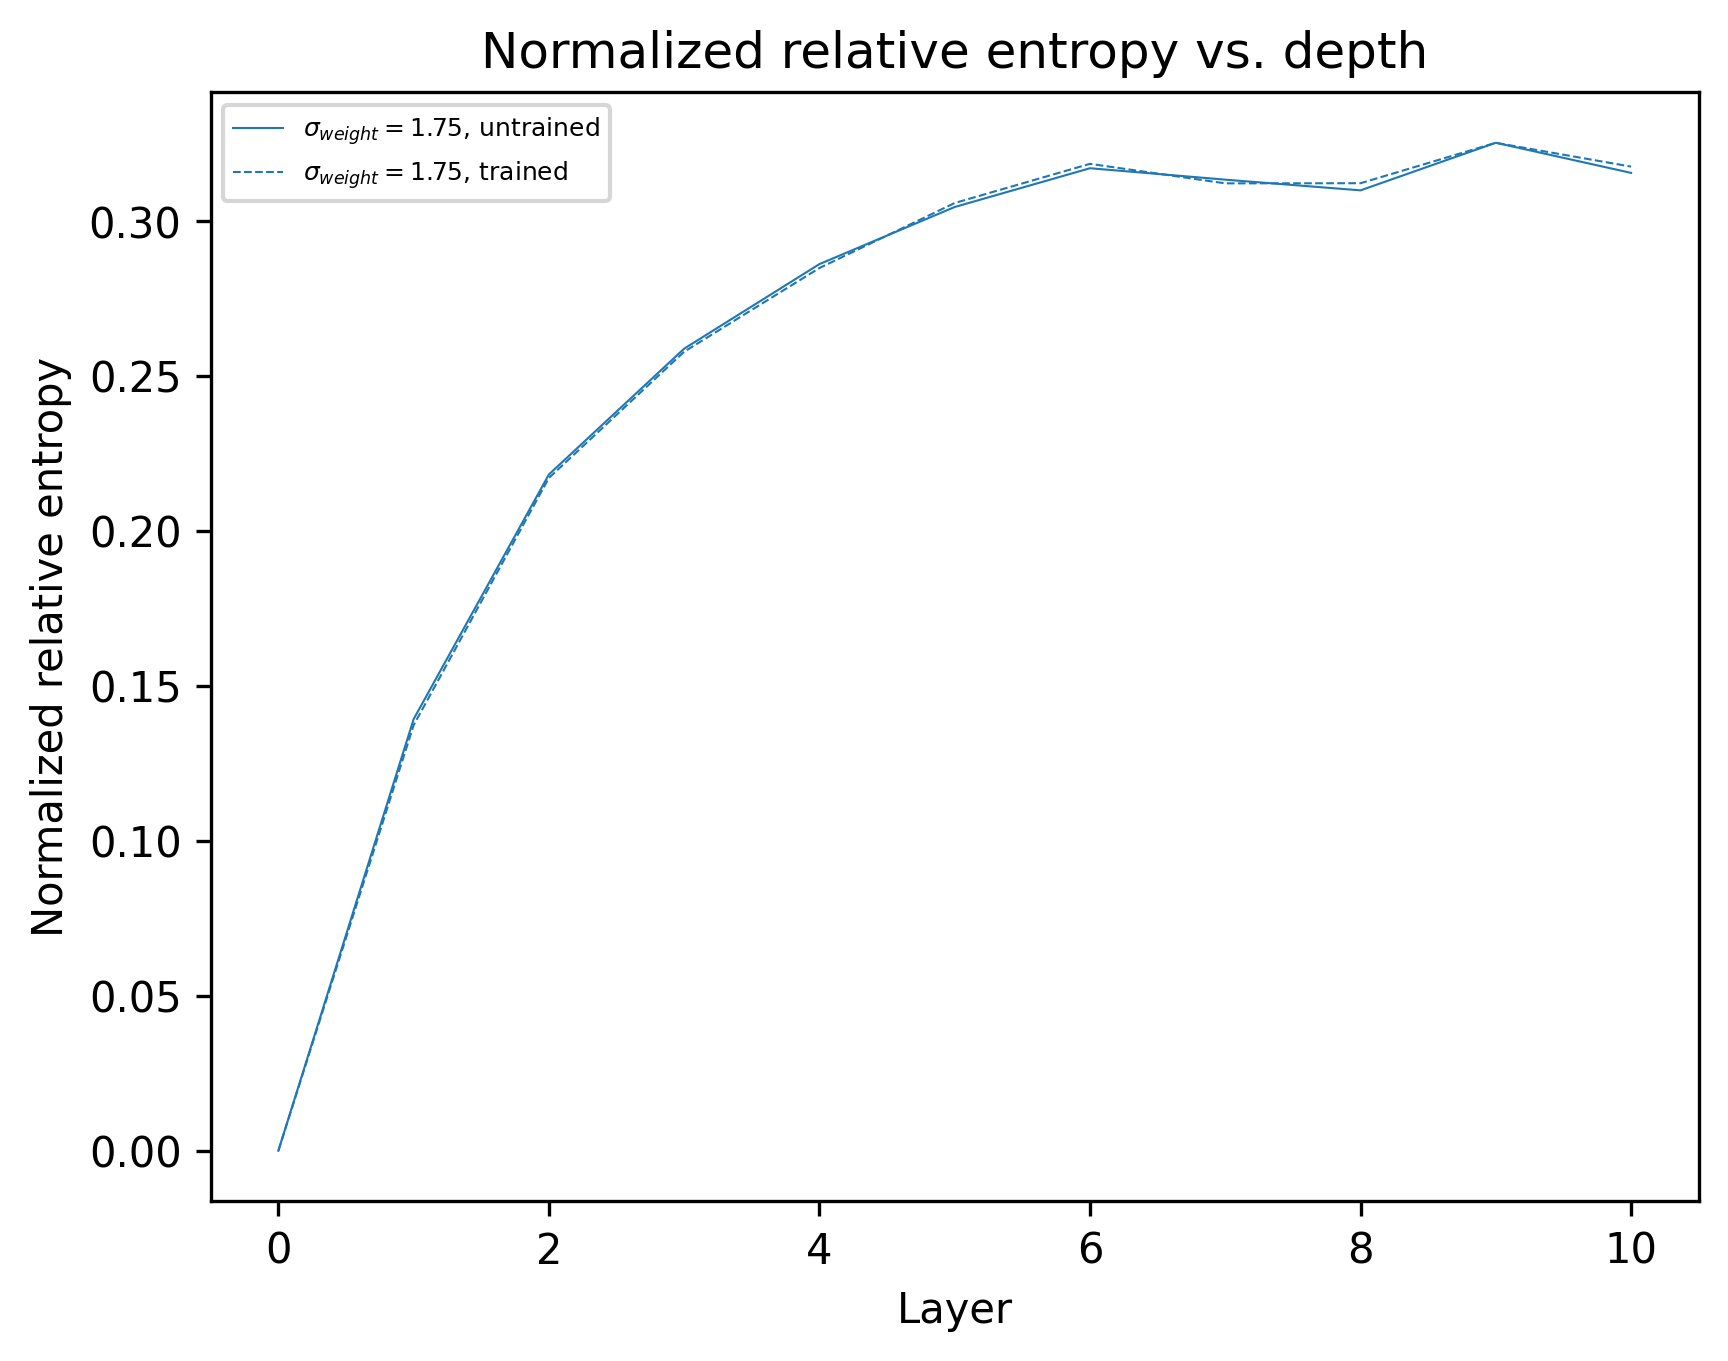

In [9]:
# __________________________________________Import libraries__________________________________________
from typing import List
import torch
import math
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import seaborn
from torch.distributions import Normal
from scipy.stats import norm

# _______________________________________Computation of the relative entropy________________________________________
# Compute the entropy (see term 1 in $(\ref{Final RE A})$)
entropy = lambda layer: math.log(2 * math.pi * math.exp(1) * (torch.std(layer, unbiased=False).item() ** 2)) * (
            layer.shape[0] / 2)

# Compute the q-entropy (see term 2 in $(\ref{Final RE A})$)
entropy_q = lambda layer: math.log(2 * math.pi * torch.std(layer, unbiased=False).item() ** 2) * (layer.shape[0] / 2)

# Compute $(\ref{first f})$ via $(\ref{MC Method first int})$ using the Monte Carlo Method (see $\ref{RECode}$),
# where $n_{MC}$ samples are drawn from the vector of activations of the reference layer $\sigma_T$
mc_int1 = lambda phi: torch.mean(phi, dim=1)

# For an autoencoder: normalize the relative entropy using the entropy of the reference layer $\cite{erdmenger2021quantifying}$
# Neglect the last layer, as it is not Gaussian (see chapter $\ref{ResultsAuto}$)
# For a multilayer perceptron: normalize the relative entropy using the entropy of the reference layer $\cite{erdmenger2021quantifying}$
# Neglect the last two layers, since their layer width differs from the other layers $\cite{erdmenger}$
f = lambda entropies, var: [entropy / (784 * math.log(2 * math.pi * math.e * var) / 2) for entropy in entropies[:-2]]

'''
Compute $(\ref{second f})$ via $(\ref{MC Method second int})$ using the Monte Carlo method (see $\ref{RECode}$)
'''
def mc_int2(phi):
    width = phi.shape[0]
    prod = torch.empty((width * width,))
    for i in range(width):
        # Compute $(\ref{MC Method second int})$
        result = torch.mean(phi * phi[i], dim=1)
        prod[i * width: (i + 1) * width] = result
    return prod

'''
This function computes $(\ref{A Final ExpandedQterm})$, which is the third term in $(\ref{Final RE A})$.
'''
def q_term(phi, weight, bias, preact):
    # Compute $(\ref{first f})$ using the Monte Carlo method
    fj = mc_int1(phi).to(device)
    # Compute $(\ref{second f})$ using the Monte Carlo method
    fjk = mc_int2(phi).to(device)
    # Define the weights in $(\ref{A Final ExpandedQterm})$
    wt = torch.transpose(weight, 0, 1).to(device)
    bshift = (bias - torch.mean(preact).to(device))
    # Compute the linear term in $(\ref{A Final ExpandedQterm})$, which is linear with respect to the weights
    linear_term = 2 * torch.sum(torch.sum(wt.to(device) * bshift.to(device), dim=1) * fj)
    # Compute the quadratic term in $(\ref{A Final ExpandedQterm})$, which is quadratic with respect to the weights
    quadratic_term = torch.tensor(0.0).to(device)
    for i in range(len(fj)):
        index = len(fj) * i
        quadratic_term += torch.sum(torch.sum(wt * wt[i], dim=1) * fjk[index: index + len(fj)])
    # Compute the constant term in $(\ref{A Final ExpandedQterm})$, which is constant with respect to the weights
    const_term = torch.sum(bshift * bshift)
    # Compute the final Q-term $(\ref{A Final ExpandedQterm})$, composed of the quadratic, linear, and constant terms
    # The standard deviation of the distribution q is not considered, as it will be included in the next step
    return (quadratic_term + linear_term + const_term).item()

'''
This function uses the configs (weights and biases) and the forwards (layers) to compute the relative entropy for a hierarchical network as a function of depth. It follows the algorithm in $\ref{Implementation RE}$.
'''
def analyse(config, forward, samples=int(1e3)):
    # entropys_sample stores the Q-term (third term in $\ref{Final RE A}$), computed for each layer of the network
    # The first Q-term stored in entropys_sample is the one for the case $m=0$, where $p=q$, and thus the Q-term is (reference layer width)/2
    entropys_sample = [forward[0].shape[0] / 2]
    # Compute the first term in $\ref{Final RE A}$, which considers only the reference layer forward[0]
    entropy_ref = -entropy(forward[0])
    # Compute the second term in $\ref{Final RE A}$, computed for each layer
    entropys_first = [entropy_q(layer) for layer in forward]
    # Define the number of samples to draw
    mask = torch.ones(samples, forward[0].shape[0], requires_grad=False)
    # Compute the mean of the reference layer
    means = torch.mean(forward[0]).item() * mask
    # Compute the standard deviation of the reference layer
    stds = torch.std(forward[0], unbiased=False).item() * mask
    # Generate $n_{MC}$ samples of the pre-activation vector of the reference layer using a Gaussian
    # whose mean and standard deviation are the same as those of the reference layer (see step 1 of the algorithm in $\ref{RECode}$)
    gaussian = torch.normal(means, stds).to(device)
    # Obtain $n_{MC}$ samples of the activation vector of the reference layer (see step 1 of the algorithm in $\ref{RECode}$)
    phi = torch.transpose(torch.tanh(gaussian), 0, 1).to(device)

    # Compute the Q-term $(\ref{A Qterm1})$ for the case $m=1$
    # Follow step 2 of the algorithm in $\ref{RECode}$ and compute $(\ref{A Qterm1})$ using forward[1] (layer at $m=1$),
    # config[0][1] (weights of layer $m=1$), and config[1][1] (biases of layer $m=1$)
    entropys_sample.append(q_term(phi, config[0][1], config[1][1], forward[1]) /
                           (2 * torch.std(forward[1], unbiased=False).item() ** 2))

    # Compute the Q-term $(\ref{A Final ExpandedQterm})$ for $m>2$
    for m in range(2, len(config[0])):
        # Follow step 3 of the algorithm in $\ref{RECode}$ and introduce the new weights and biases to the activation vector $\sigma_T$
        # to compute the new activation vector
        phi = torch.tanh(torch.matmul(config[0][m - 1], phi) + config[1][m - 1][:, None])
        # Compute the Q-term $(\ref{A Final ExpandedQterm})$ using forward[m] (layers $m>2$) along with the weights and biases
        entropys_sample.append(q_term(phi, config[0][m], config[1][m], forward[m]) /
                               (2 * torch.std(forward[m], unbiased=False).item() ** 2))

    # Compute the final relative entropy for all $m$ layers of the neural network (see equation $(\ref{Final RE A})$ with $l=0$).
    return [entropy_ref + entropy_first + entropy_sample for entropy_first, entropy_sample in
            zip(entropys_first, entropys_sample)]

'''
This function takes each entry from the config_forwards list. From each entry, it extracts the configs (weights and biases) and the layers.
Then it passes these to the function $analyse(data[0], data[1])$.
'''
def worker(data):
    # Returns the relative entropy of a deep neural network as a function of depth (see $\ref{Final RE A}$)
    return analyse(data[0], data[1])

'''
This function receives file names of different networks, opens the corresponding pickle files,
and retrieves the layers and parameters stored in these files for the relative entropy program.
'''
def analyse_set(*files):
    # Store weights, biases, and layers
    config_forwards = []
    # Store weight variances $\sigma_w^2$
    vars_ = []
    # Read layers and parameters of each neural network stored in pickle files
    for file in files:
        # Open the pickle files and retrieve their content
        with open(f"{file}.pkl", "rb") as doc:
            # header stores the weight variances $\sigma_w^2$
            # first_config stores the weights and biases before training
            # first_forward stores the layers before training
            # last_config stores the weights and biases after training
            # last_forward stores the layers after training
            header, first_config, first_forward, last_config, last_forward = pickle.load(doc)
            # Unpack and store the layers before training
            first_forward = [e[0, :] for e in first_forward]
            # Unpack and store the layers after training
            last_forward = [e[0, :] for e in last_forward]
            # Store layers before and after training along with weights and biases
            config_forwards.append((first_config, first_forward))
            config_forwards.append((last_config, last_forward))
            # Unpack and store the weight variances $\sigma_w^2$
            vars_.append(header[0])
            vars_.append(header[0])

    # Pass each entry of the list config_forwards to the worker function and store the output as a list
    # This list contains the relative entropies of all layers for each neural network
    entropiess = list(map(worker, config_forwards))

    # __________________________________________Visualization_________________________________________
    # Plot the relative entropy for a hierarchical network as a function of depth before and after training
    for i in range(0, len(entropiess), 2):
        # Relative entropy before training
        entropy1 = entropiess[i]
        # Relative entropy after training
        entropy2 = entropiess[i + 1]

        # Normalize the plot
        plt.grid()
        # Normalize the relative entropy before training using $f(entropy1, vars$_$[i][0])$
        p = plt.plot(f(entropy1, vars_[i][0]), label=f"$\\sigma_{{weight}} = {vars_[i][0]}$, untrained", linewidth=0.5)
        color = p[0].get_color()
        # Normalize the relative entropy after training using $f(entropy2, vars$_$[i+1][0])$
        plt.plot(f(entropy2, vars_[i + 1][0]), "",
                 label=f"$\\sigma_{{weight}} = {vars_[i + 1][0]}$, trained",
                 color=color,
                 linestyle="--", linewidth=0.5)

    plt.xlabel("Layer")
    plt.ylabel("Normalized relative entropy")
    plt.title("Normalized relative entropy vs. depth")
    plt.legend(prop={'size': 6})
    plt.grid()
    return entropiess

# Start the program and process the pickle files
if __name__ == "__main__":
    analyse_set(#"var=(0.75, 0.05)_depth=40_data",
                #"var=(1.0, 0.05)_depth=40_data",
                #"var=(1.25, 0.05)_depth=40_data",
                #"var=(1.5, 0.05)_depth=40_data",
                "var=(1.75, 0.05)_depth=40_data")
                #"var=(2.0, 0.05)_depth=40_data")
                #"var=(2.25, 0.05)_depth=40_data",
                #"var=(20.0, 0.05)_depth=40_data")
                #"var=(2.75, 0.05)_depth=40_data")
                #"var=(3.0, 0.05)_depth=40_data",
                #"var=(3.5, 0.05)_depth=40_data")

In [ ]:
from typing import List
import torch
import math
import pickle
import matplotlib.pyplot as plt
import seaborn
from torch.distributions import Normal
from scipy.stats import norm

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

entropy = lambda layer: math.log(2 * math.pi * math.exp(1) * (torch.std(layer, unbiased=False).item() ** 2)) * (
    layer.shape[0] / 2)
entropy_q = lambda layer: math.log(2 * math.pi * torch.std(layer, unbiased=False).item() ** 2) * (layer.shape[0] / 2)
mc_int1 = lambda phi: torch.mean(phi, dim=1)
f = lambda entropies, var: [entropy / (784 * math.log(2 * math.pi * math.e * var) / 2) for entropy in entropies[:-2]]

def mc_int2(phi):
    width = phi.shape[0]
    prod = torch.empty((width * width,))
    for i in range(width):
        result = torch.mean(phi * phi[i], dim=1)
        prod[i * width: (i + 1) * width] = result
    return prod

def q_term(phi, weight, bias, preact):
    fj = mc_int1(phi).to(device)
    fjk = mc_int2(phi).to(device)
    wt = torch.transpose(weight, 0, 1).to(device)
    bshift = (bias - torch.mean(preact).to(device))

    linear_term = 2 * torch.sum(torch.sum(wt.to(device) * bshift.to(device), dim=1) * fj)
    quadratic_term = torch.tensor(0.0).to(device)
    for i in range(len(fj)):
        index = len(fj) * i
        quadratic_term += torch.sum(torch.sum(wt * wt[i], dim=1) * fjk[index: index + len(fj)])
    const_term = torch.sum(bshift * bshift)
    return (quadratic_term + linear_term + const_term).item()

def analyse(config, forward, samples=int(1e3)):
    entropy_ref = - entropy(forward[0])
    entropys_first = [entropy_q(layer) for layer in forward]
    entropys_sample = [forward[0].shape[0] / 2]

    mask = torch.ones(samples, forward[0].shape[0], requires_grad=False)
    means = torch.mean(forward[0]).item() * mask
    stds = torch.std(forward[0], unbiased=False).item() * mask
    gaussian = torch.normal(means, stds).to(device)
    phi = torch.transpose(torch.tanh(gaussian), 0, 1).to(device)

    entropys_sample.append(q_term(phi, config[0][1], config[1][1], forward[1]) / (2 * torch.std(forward[1], unbiased=False).item() ** 2))

    for m in range(2, len(config[0])):
        phi = torch.tanh(torch.matmul(config[0][m - 1], phi) + config[1][m - 1][:, None])
        entropys_sample.append(q_term(phi, config[0][m], config[1][m], forward[m]) / (2 * torch.std(forward[m], unbiased=False).item() ** 2))

    return [entropy_ref + entropy_first + entropy_sample for entropy_first, entropy_sample in zip(entropys_first, entropys_sample)]

def worker(data):
    return analyse(data[0], data[1])

def analyse_set(*files):
    config_forwards = []
    vars_ = []
    for file in files:
        with open(f"{file}.pkl", "rb") as doc:
            header, first_config, first_forward, last_config, last_forward = pickle.load(doc)
            first_forward = [e[0, :] for e in first_forward]
            last_forward = [e[0, :] for e in last_forward]
            config_forwards.append((first_config, first_forward))
            config_forwards.append((last_config, last_forward))
            vars_.append(header[0])
            vars_.append(header[0])

            layer0 = last_forward[0].to(device)
            layer5 = last_forward[2].to(device)
            seaborn.distplot(layer0.cpu(), kde=True, color='dodgerblue', fit_kws={"color": "blue"}, label="p-distribution of layer 0")
            seaborn.distplot(layer5.cpu(), kde=True, color='tomato', fit_kws={"color": "red"}, label="q-distribution of layer 95")

    entropiess = list(map(worker, config_forwards))

    for i in range(0, len(entropiess), 2):
        entropy1 = entropiess[i]
        entropy2 = entropiess[i + 1]

        plt.grid()
        plt.xlabel("pre-activation")
        plt.ylabel("p(pre-activation)")
        plt.title("Layer distribution")
        plt.legend(prop={'size': 6})
        plt.grid()
    return entropiess

if __name__ == "__main__":
    analyse_set("var=(1.75, 0.05)_depth=40_data")